In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.parallel
        
def weights_init(m):
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)): 
        m.weight.data.normal_(0.0, 0.02)
        # m.bias.data.fill_(0)
    elif isinstance(m, nn.Linear):
        m.weight.data.normal_(0.0, 0.02)
        # m.bias.data.fill_(0)
    elif isinstance(m, (nn.BatchNorm1d, nn.BatchNorm2d)):
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

class LinearBlock(nn.Module):
    def __init__(self, in_f, out_f, bn=True, act='relu'):
        super(LinearBlock, self).__init__()
        self.bn = bn
        self.act = act
        
        if act == 'relu':
            self.act_f = F.relu
        elif act == 'lrelu':
            self.act_f = F.leaky_relu
        else:
            self.act_f = lambda x: x
            
        self.fc = nn.Linear(in_f, out_f, bias=False)
        #self.bn = nn.BatchNorm1d(out_f)
    
    def forward(self, x):
        out = self.fc(x)
        #if self.bn: out = self.bn(out)
        out = self.act_f(out)
            
        return out

class ConvBlock(nn.Module):
    def __init__(self, in_f, out_f, bn=True, act='relu', mode='up'):
        super(ConvBlock, self).__init__()
        self.bn = bn
        self.act = act
        
        if act == 'relu':
            self.act_f = F.relu
        elif act == 'lrelu':
            self.act_f = F.leaky_relu
        else:
            self.act_f = lambda x: x
            
        #self.conv1 = nn.Conv2d(in_f, in_f, 1, 1, 0, bias=False)
        #self.bn1 = nn.BatchNorm2d(in_f)
        if mode == 'up':
            self.conv2 = nn.ConvTranspose2d(in_f, out_f, 4, 2, 1, bias=False)
        elif mode == 'down':
            self.conv2 = nn.Conv2d(in_f, out_f, 4, 2, 1, bias=False)
            
        self.bn2 = nn.BatchNorm2d(out_f)
    
    def forward(self, x):
        #out = self.conv1(x)
        #if self.bn: out = self.bn1(out)
        #out = self.act_f(out)
        out = self.conv2(x)
        if self.bn: out = self.bn2(out)
        out = self.act_f(out)
            
        return out
    

class G(nn.Module):
    def __init__(self, features):
        super(G, self).__init__()
        self.features = features
        self.linear = LinearBlock(features, 4*4*features)
        self.upconv1 = ConvBlock(features, features)
        self.upconv2 = ConvBlock(features, features)
        self.upconv3 = ConvBlock(features, features)
        self.upconv4 = ConvBlock(features, features)
        self.upconv5 = ConvBlock(features, features)
        self.final = nn.Conv2d(features, 3, 3, 1, 1, bias=False)

    def forward(self, x):
        out = self.linear(x)
        out = out.view([-1,self.features,4,4])
        out = self.upconv1(out)
        out = self.upconv2(out)
        out = self.upconv3(out)
        out = self.upconv4(out)
        out = self.upconv5(out)
        out = self.final(out)
        out = F.tanh(out)
        
        return out

    
class D(nn.Module):
    def __init__(self, features):
        super(D, self).__init__()
        self.conv1 = ConvBlock(3, features, bn=False, act='lrelu', mode='down')
        self.conv2 = ConvBlock(features, features, bn=False, act='lrelu', mode='down')
        self.conv3 = ConvBlock(features, features, bn=False, act='lrelu', mode='down')
        self.conv4 = ConvBlock(features, features, bn=False, act='lrelu', mode='down')
        self.conv5 = ConvBlock(features, features, bn=False, act='lrelu', mode='down')
        self.conv6 = ConvBlock(features, features, bn=False, act='lrelu', mode='down')
        self.fc1 = LinearBlock(128*2*2, 512, bn=False, act='lrelu')
        self.fc2 = nn.Linear(512, 1, bias=False)
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.conv5(out)
        out = self.conv6(out)
        out = out.view([-1, 128*2*2])
        out = self.fc1(out)
        out = self.fc2(out)
        
        return out

In [4]:
import torch
import random
import numpy as np
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms, utils
%matplotlib inline

bs,sz,nz = 32,128,128
LAMBDA = 10
PATH_G = 'iwgancv5_g'
PATH_D = 'iwgancv5_d'

PATH = '/home/m20163692/data/lsun'
data = datasets.LSUN(db_path=PATH, classes=['church_outdoor_train'],
    transform=transforms.Compose([
        transforms.Scale(sz),
        transforms.CenterCrop(sz),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
]))

dataloader = torch.utils.data.DataLoader(data, bs, True, num_workers=8, pin_memory=True)
n = len(dataloader); n

3945

# START

In [5]:
import os, sys
sys.path.append(os.getcwd())

import time
import numpy as np
import sklearn.datasets

import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

use_cuda = torch.cuda.is_available()
if use_cuda:
    gpu = 0

import torch.nn as nn
from torch import optim
from torch.autograd import Variable, grad

def inf_train_gen():
    while True:
        for images,targets in train_gen():
            yield images

def calc_gradient_penalty(netD, real_data, fake_data):
    #print real_data.size()
    alpha = torch.rand(bs,1,1,1)
    alpha = alpha.expand(real_data.size())
    alpha = alpha.cuda(gpu) if use_cuda else alpha

    interpolates = alpha * real_data + ((1 - alpha) * fake_data)

    if use_cuda:
        interpolates = interpolates.cuda(gpu)
    interpolates = autograd.Variable(interpolates, requires_grad=True)

    disc_interpolates = netD(interpolates)

    gradients = autograd.grad(outputs=disc_interpolates, inputs=interpolates,
                              grad_outputs=torch.ones(disc_interpolates.size()).cuda(gpu) if use_cuda else torch.ones(
                                  disc_interpolates.size()),
                              create_graph=True, retain_graph=True, only_inputs=True)[0]

    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean() * LAMBDA
    return gradient_penalty

# ==================Definition End======================

In [6]:
netG = G(nz).cuda()
netG.apply(weights_init);

netD = D(nz).cuda()
netD.apply(weights_init);

if use_cuda:
    netD = netD.cuda(gpu)
    netG = netG.cuda(gpu)

optimizerD = optim.Adam(netD.parameters(), lr=1e-4, betas=(0.5, 0.9))
optimizerG = optim.Adam(netG.parameters(), lr=1e-4, betas=(0.5, 0.9))

one = torch.FloatTensor([1])
mone = one * -1
if use_cuda:
    one = one.cuda(gpu)
    mone = mone.cuda(gpu)
    
data_iter = iter(dataloader)

In [ ]:
for iteration in range(1000):
    start_time = time.time()
    ############################
    # (1) Update D network
    ###########################
    for p in netD.parameters():  # reset requires_grad
        p.requires_grad = True  # they are set to False below in netG update

    for iter_d in range(5):
        real_data = next(data_iter)[0]
#         real_data = torch.Tensor(_data)
        if use_cuda:
            real_data = real_data.cuda(gpu)
        real_data_v = autograd.Variable(real_data)

        netD.zero_grad()

        # train with real
        D_real = netD(real_data_v)
        D_real = D_real.mean()
        # print D_real
        D_real.backward(mone)

        # train with fake
        noise = torch.randn(bs, 128)
        if use_cuda:
            noise = noise.cuda(gpu)
        noisev = autograd.Variable(noise, volatile=True)  # totally freeze netG
        fake = autograd.Variable(netG(noisev).data)
        inputv = fake
        D_fake = netD(inputv)
        D_fake = D_fake.mean()
        D_fake.backward(one)

        # train with gradient penalty
        gradient_penalty = calc_gradient_penalty(netD, real_data_v.data, fake.data)
        gradient_penalty.backward()

        D_cost = D_fake - D_real + gradient_penalty
        print('%.2f' % D_cost.data[0], end=', ')
        Wasserstein_D = D_real - D_fake
        optimizerD.step()

    ############################
    # (2) Update G network
    ###########################
    for p in netD.parameters():
        p.requires_grad = False  # to avoid computation
    netG.zero_grad()

    noise = torch.randn(bs, 128)
    if use_cuda:
        noise = noise.cuda(gpu)
    noisev = autograd.Variable(noise)
    fake = netG(noisev)
    G = netD(fake)
    G = G.mean()
    G.backward(mone)
    G_cost = -G
    optimizerG.step()


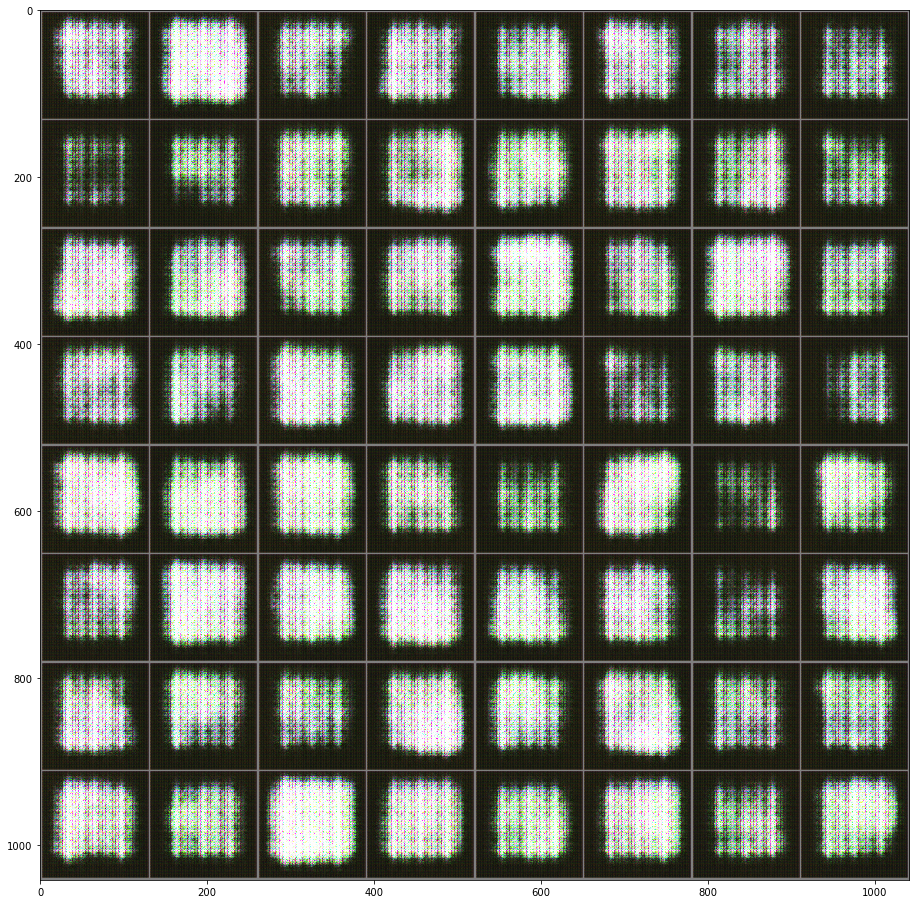

In [12]:
def show(img, fs=(8,8)):
    plt.figure(figsize = fs)
    plt.imshow(np.transpose((img/2+0.5).clamp(0,1).numpy(), (1,2,0)), interpolation='nearest')
    plt.show()
# model mode eval
netG.eval()
fixed_noise = Variable(torch.randn(64, 128).cuda(), volatile=True)
fake = netG(fixed_noise).data.cpu()
show(utils.make_grid(fake), (16,16))